<a href="https://colab.research.google.com/github/skorpiom/traffic_sign_rec/blob/master/traffic_sign_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!rm -rf sample_data
!rm -rf train_and_valid_signs

In [0]:
%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import VGG19

np.set_printoptions(precision = 6, suppress = True)

In [3]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
!unzip -q GTSRB-Training_fixed.zip

--2019-12-28 11:13:08--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 187490228 (179M) [application/zip]
Saving to: ‘GTSRB-Training_fixed.zip’

GTSRB-Training_fixe 100%[===================>] 178.80M  18.2MB/s    in 11s     

2019-12-28 11:13:19 (16.4 MB/s) - ‘GTSRB-Training_fixed.zip’ saved [187490228/187490228]



In [40]:
base_dir = './GTSRB/Training'
raw_no_of_files = {}
classes = []
for n in range(0,43):
  if n<10:
    classes.append("0000"+str(n))
  else:
    classes.append("000"+str(n))

for dir in classes:
  raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir,dir)))

raw_no_of_files.items()

dict_items([('00000', 151), ('00001', 1501), ('00002', 1501), ('00003', 961), ('00004', 1321), ('00005', 1261), ('00006', 301), ('00007', 961), ('00008', 961), ('00009', 991), ('00010', 1351), ('00011', 901), ('00012', 1411), ('00013', 1441), ('00014', 541), ('00015', 421), ('00016', 301), ('00017', 751), ('00018', 811), ('00019', 151), ('00020', 241), ('00021', 241), ('00022', 271), ('00023', 361), ('00024', 181), ('00025', 1021), ('00026', 421), ('00027', 181), ('00028', 361), ('00029', 181), ('00030', 301), ('00031', 541), ('00032', 181), ('00033', 481), ('00034', 301), ('00035', 811), ('00036', 271), ('00037', 151), ('00038', 1381), ('00039', 211), ('00040', 241), ('00041', 181), ('00042', 181)])

In [0]:
data_dir = './train_and_valid_signs'
dirs_train = []
dirs_valid = []

train_dir = os.path.join(data_dir,'train') #katalog treningowy
valid_dir = os.path.join(data_dir,'valid') #katalog walidacyjny

for n in range(0,43):
  dirs_train.append(os.path.join(train_dir,classes[n])) #sciezki z katalogami docelowymi zbior treningowy

for n in range(0,43):
  dirs_valid.append(os.path.join(valid_dir,classes[n])) #sciezki z katalogami docelowymi zbior walidacyjny

if not os.path.exists(data_dir):
  os.mkdir(data_dir)
  
for directory in (train_dir,valid_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)

for directory in dirs_train:
  if not os.path.exists(directory):
    os.mkdir(directory)

for directory in dirs_valid:
  if not os.path.exists(directory):
    os.mkdir(directory)

#DISPLAY INDICATED SIGN

./GTSRB/Training/00000/00001_00010.ppm


(-0.5, 35.5, 34.5, -0.5)

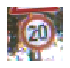

In [6]:
img_path = os.path.join('./GTSRB','Training','00000','00001_00010.ppm')
print(img_path)
img = image.load_img(img_path)
plt.figure(figsize=(1,1))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [42]:
sign_fnames = []
for ind in range(0,43):
  sign_fnames.append(os.listdir(os.path.join(base_dir,classes[ind])))  

print('00000 liczba obiektow: ',len(sign_fnames[0]))
print('00001 liczba obiektow: ',len(sign_fnames[1]))

00000 liczba obiektow:  151
00001 liczba obiektow:  1501


In [0]:
for i,fname in enumerate(sign_fnames):
  for j,name in enumerate(fname):
    if j<=0.8*int(np.floor(len(fname))):
      src = os.path.join(base_dir,classes[i],name)
      dst = os.path.join(dirs_train[i],name)
      shutil.copyfile(src,dst)
    if 0.8*int(np.floor(len(fname))) < j <= len(fname):
      src = os.path.join(base_dir,classes[i],name)
      dst = os.path.join(dirs_valid[i],name)
      shutil.copyfile(src,dst)

In [44]:
print('00000 zbior treningowy ',len(os.listdir(dirs_train[0])))
print('00000 zbior walidacyjny ',len(os.listdir(dirs_valid[0])))

print('00001 zbior treningowy ',len(os.listdir(dirs_train[1])))
print('00001 zbior walidacyjny ',len(os.listdir(dirs_valid[1])))

00000 zbior treningowy  121
00000 zbior walidacyjny  30
00001 zbior treningowy  1201
00001 zbior walidacyjny  300


#AUGMENTACJA DANYCH

In [45]:
train_datagen = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255.,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valid_datagen = ImageDataGenerator(rescale = 1./255.) #przeskalowanie danych

train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size=(32,32),
                                                    batch_size = 8,
                                                    class_mode='categorical')
valid_generator = train_datagen.flow_from_directory(directory = valid_dir,
                                                    target_size=(32,32),
                                                    batch_size = 8,
                                                    class_mode='categorical')

Found 21319 images belonging to 43 classes.
Found 5321 images belonging to 43 classes.


#BUDOWA MODELU

In [91]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),activation='relu',input_shape=(32, 32, 3)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation='relu'))
model.add(layers.Dense(units=43, activation='softmax'))
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_63 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 4, 4, 128)         147584    
_________________________________________________________________
flatten_16 (Flatten)         (None, 2048)            

In [0]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
!rm -rf logs
!mkdir logs
tensorboard = TensorBoard(log_dir='logs')

In [94]:
history = model.fit_generator(generator=train_generator,
                              epochs = 30,
                              validation_data = valid_generator,
                              callbacks = [tensorboard])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2665 steps, validate for 666 steps
Epoch 1/30
2665/2665 [==============================] - 33s 13ms/step - loss: 2.8807 - accuracy: 0.1909 - val_loss: 2.4456 - val_accuracy: 0.2983
Epoch 2/30
2665/2665 [==============================] - 33s 12ms/step - loss: 2.1600 - accuracy: 0.3546 - val_loss: 1.8616 - val_accuracy: 0.4227
Epoch 3/30
2665/2665 [==============================] - 32s 12ms/step - loss: 1.7366 - accuracy: 0.4573 - val_loss: 1.5320 - val_accuracy: 0.5129
Epoch 4/30
2665/2665 [==============================] - 32s 12ms/step - loss: 1.4866 - accuracy: 0.5248 - val_loss: 1.4312 - val_accuracy: 0.5499
Epoch 5/30
2665/2665 [==============================] - 31s 12ms/step - loss: 1.3301 - accuracy: 0.5768 - val_loss: 1.2733 - val_accuracy: 0.5792
Epoch 6/30
2665/2665 [==============================] - 31s 12ms/step - loss: 1.2128 - accuracy: 0.6130 - val_loss: 1.1581 - val_accuracy: 0.6168
Epoch 7/30
2665/2665 [=======

In [95]:
%load_ext tensorboard
!tensorboard dev upload --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.
View your TensorBoard live at: https://tensorboard.dev/experiment/RetMQKdPQwCMglxF6OGoYA/

Upload stopped. View your TensorBoard at https://tensorboard.dev/experiment/RetMQKdPQwCMglxF6OGoYA/
Exception ignored in: <bound method PyRecordReader.<lambda> of <tensorflow.python.pywrap_tensorflow_internal.PyRecordReader; proxy of <Swig Object of type 'tensorflow::io::PyRecordReader *' at 0x7f630cbbc570> >>
Traceback (most recent call last):
  File "/tensorflow-2.1.0/python3.6/tensorflow_core/python/pywrap_tensorflow_internal.py", line 903, in <lambda>
    __del__ = lambda self: None
KeyboardInterrupt
